In [1]:
import sys
sys.path.append("..")
import shap
import xgboost
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import colorsys
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.model_selection import train_test_split

In [2]:
shap.initjs()

In [3]:
# train XGBoost model
X,y = shap.datasets.communitiesandcrime()
X = X.reset_index()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 1000)

In [4]:
X_instanced = pd.concat((X,pd.DataFrame(columns = ['instance'])),axis = 1)
X_instanced['instance'].loc[X_train.index] = 'train'
X_instanced['instance'].loc[X_test.index] = 'test'
y_instanced = pd.concat((pd.DataFrame(y),pd.DataFrame(columns = ['instance'])),axis = 1)
y_instanced['instance'].loc[X_train.index] = 'train'
y_instanced['instance'].loc[X_test.index] = 'test'

C:\Users\koral\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [6]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [7]:
# visualize the training set predictions
#shap.force_plot(explainer.expected_value, shap_values, X)

In [8]:
# summarize the effects of all the features
#shap.summary_plot(shap_values, X,plot_type = 'bar')

In [9]:
# summarize the effects of all the features
#shap.summary_plot(shap_values, X)

In [10]:
#Gather shapley values and output values in one dataframe
shap_dataframe = pd.DataFrame(data = shap_values,columns = X.columns)
output_dataframe = pd.DataFrame(data = y,columns = ['crimes'])
shap_dataframe = pd.concat([shap_dataframe,output_dataframe],axis = 1)

In [11]:
#Make interaction plot for all features
#shap_interaction_values = explainer.shap_interaction_values(X)
#shap.summary_plot(shap_interaction_values, X, max_display = 10)

In [12]:
from Framework import plotHelper
#plotHelper.plotAllFeatures(shap_dataframe)

In [13]:
#Start clustering
from Framework import cluster
from sklearn.cluster import KMeans
nClusters = 3
#Train KMeans, because the data is unsupervised(Regression data)
#kmeans = KMeans(n_clusters=3, random_state=0).fit(shap_values)
kmeans = cluster.clusterData(KMeans(n_clusters=nClusters, random_state=0).fit,shap_values)

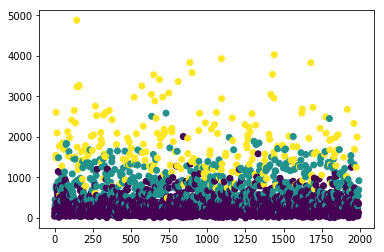

In [14]:
#Get the labels, concat into original data, and sor the labels for into cluster groups
shap_dataframe_labeled = pd.concat([shap_dataframe,pd.DataFrame(kmeans.labels_,columns =[ 'labels'])],axis = 1)
#shap_grouped = shap_dataframe_labeled.sort_values(['labels'])
X_labeled = pd.concat([X,shap_dataframe_labeled['labels']], axis = 1)
plt.scatter(np.linspace(0,len(X),len(X)),y,c = X_labeled['labels'])

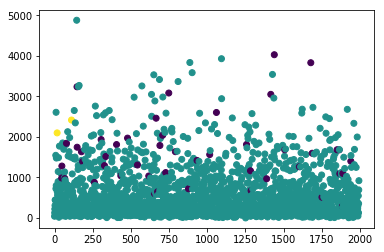

In [15]:
kmeans_original = cluster.clusterData(KMeans(n_clusters=nClusters, random_state=0).fit,X)
plt.scatter(np.arange(len(X)),y,c = kmeans_original.labels_)

In [16]:
#Split the clusters into a dictionary
data_dict = cluster.splitDataLabeled(nClusters,shap_dataframe,shap_dataframe_labeled['labels'])
data_dict_original = cluster.splitDataLabeled(nClusters,X,kmeans_original.labels_)

In [17]:
original_split = cluster.convertOriginalData(data_dict_original,X_instanced,y_instanced)
original_split_shapley = cluster.convertOriginalData(data_dict,X_instanced,y_instanced)

In [18]:
original_split

{'original_data_cluster0':       index  population  householdsize  racepctblack  racePctWhite  \
 47       54      332943           2.54         19.70         76.96   
 48       55     1585577           2.63         39.86         53.52   
 67       78      405390           2.49          4.28         75.25   
 78       90      437319           2.34          7.67         84.64   
 147     166      280015           2.44         25.05         70.90   
 148     167     1006877           2.50         29.50         55.30   
 176     195      429433           2.70         13.68         58.38   
 184     205      444719           2.49         15.98         74.78   
 261     294      304011           2.47         11.28         82.29   
 305     343      328123           2.40         30.65         64.75   
 327     370      369365           2.56         15.30         60.09   
 336     379      447619           2.66         22.01         63.79   
 406     454      723959           2.37         10.

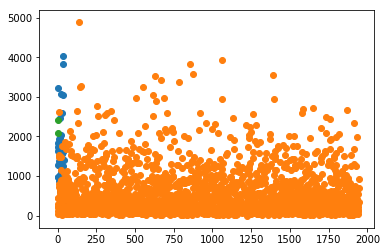

In [19]:
#Scatter the groups again...
#plt.scatter(np.linspace(-1,1,len(original_label_cluster2)),cluster2_predictions)
plt.scatter(np.arange(len(original_split['original_label_cluster0'])),original_split['original_label_cluster0'].iloc[:,0])
plt.scatter(np.arange(len(original_split['original_label_cluster1'])),original_split['original_label_cluster1'].iloc[:,0])
plt.scatter(np.arange(len(original_split['original_label_cluster2'])),original_split['original_label_cluster2'].iloc[:,0])

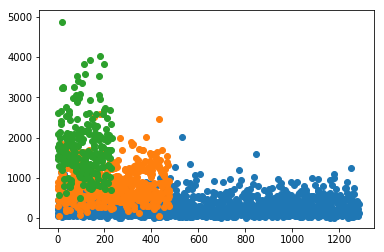

In [20]:
plt.scatter(np.arange(len(original_split_shapley['original_label_cluster0'])),original_split_shapley['original_label_cluster0'].iloc[:,0])
plt.scatter(np.arange(len(original_split_shapley['original_label_cluster1'])),original_split_shapley['original_label_cluster1'].iloc[:,0])
plt.scatter(np.arange(len(original_split_shapley['original_label_cluster2'])),original_split_shapley['original_label_cluster2'].iloc[:,0])

In [21]:
#Train split XGBoost models over original data
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse"
}

eval_results = {}
kwargs = {
    'num_boost_round':10000,
    'verbose_eval': 1000,
    'evals_result' : {},
    'early_stopping_rounds' : 200
}

model_dict,eval_results = cluster.trainMultipleModels(xgboost.train,original_split,'XGBoost',params,**kwargs)
#small_model_1 = xgboost.train(params,xgboost.DMatrix(original_split['original_data_cluster0'], label=original_split['original_label_cluster0']),20000,evals = [(xgboost.DMatrix(original_split['original_data_cluster0'], label=original_split['original_label_cluster0']), "train")] ,verbose_eval = 1000)
#small_model_2 = xgboost.train(params,xgboost.DMatrix(original_split['original_data_cluster1'], label=original_split['original_label_cluster1']),20000,evals = [(xgboost.DMatrix(original_split['original_data_cluster1'], label=original_split['original_label_cluster1']), "train")] ,verbose_eval = 1000)
#small_model_3 = xgboost.train(params,xgboost.DMatrix(original_split['original_data_cluster2'], label=original_split['original_label_cluster2']),20000,evals = [(xgboost.DMatrix(original_split['original_data_cluster2'], label=original_split['original_label_cluster2']), "train")] ,verbose_eval = 1000)

[0]	train-rmse:1237.53	test-rmse:1313.35
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[205]	train-rmse:146.268	test-rmse:559.785

[0]	train-rmse:563.697	test-rmse:623.57
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[280]	train-rmse:320.646	test-rmse:385.62

[0]	train-rmse:1825.69	test-rmse:1508.63
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[140]	train-rmse:318.233	test-rmse:1.1731



In [22]:
#Train split XGBoost models over original data
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse"
}
eval_results_shapley = {}
kwargs = {
    'num_boost_round':10000,
    'verbose_eval': 1000,
    'evals_result' : {},
    'early_stopping_rounds' : 200
}
model_dict_shapley,eval_results_shapley = cluster.trainMultipleModels(xgboost.train,original_split_shapley,'XGBoost',params,**kwargs)
#small_model_shapley1 = xgboost.train(params,xgboost.DMatrix(original_split_shapley['original_data_cluster0'], label=original_split_shapley['original_label_cluster0']),20000,evals = [(xgboost.DMatrix(original_split_shapley['original_data_cluster0'], label=original_split_shapley['original_label_cluster0']), "train")] ,verbose_eval = 1000)
#small_model_shapley2 = xgboost.train(params,xgboost.DMatrix(original_split_shapley['original_data_cluster1'], label=original_split_shapley['original_label_cluster1']),20000,evals = [(xgboost.DMatrix(original_split_shapley['original_data_cluster1'], label=original_split_shapley['original_label_cluster1']), "train")] ,verbose_eval = 1000)
#small_model_shapley3 = xgboost.train(params,xgboost.DMatrix(original_split_shapley['original_data_cluster2'], label=original_split_shapley['original_label_cluster2']),20000,evals = [(xgboost.DMatrix(original_split_shapley['original_data_cluster2'], label=original_split_shapley['original_label_cluster2']), "train")] ,verbose_eval = 1000)

[0]	train-rmse:372.064	test-rmse:365.617
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[282]	train-rmse:173.528	test-rmse:160.84

[0]	train-rmse:478.889	test-rmse:454.951
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[177]	train-rmse:316.534	test-rmse:383.772

[0]	train-rmse:1295.72	test-rmse:1537.63
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[381]	train-rmse:323.972	test-rmse:841.203



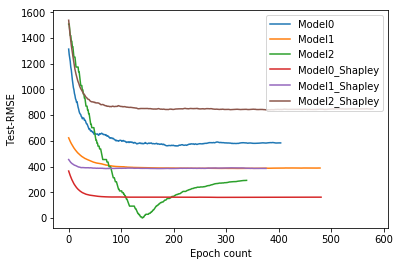

In [23]:
plt.plot(np.arange(len(eval_results['eval0']['test']['rmse'])),eval_results['eval0']['test']['rmse'])
plt.plot(np.arange(len(eval_results['eval1']['test']['rmse'])),eval_results['eval1']['test']['rmse'])
plt.plot(np.arange(len(eval_results['eval2']['test']['rmse'])),eval_results['eval2']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval0']['test']['rmse'])),eval_results_shapley['eval0']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval1']['test']['rmse'])),eval_results_shapley['eval1']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval2']['test']['rmse'])),eval_results_shapley['eval2']['test']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Test-RMSE')
plt.legend(['Model0','Model1','Model2','Model0_Shapley','Model1_Shapley','Model2_Shapley'])

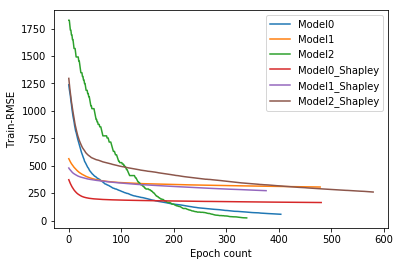

In [24]:
plt.plot(np.arange(len(eval_results['eval0']['train']['rmse'])),eval_results['eval0']['train']['rmse'])
plt.plot(np.arange(len(eval_results['eval1']['train']['rmse'])),eval_results['eval1']['train']['rmse'])
plt.plot(np.arange(len(eval_results['eval2']['train']['rmse'])),eval_results['eval2']['train']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval0']['train']['rmse'])),eval_results_shapley['eval0']['train']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval1']['train']['rmse'])),eval_results_shapley['eval1']['train']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval2']['train']['rmse'])),eval_results_shapley['eval2']['train']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Train-RMSE')
plt.legend(['Model0','Model1','Model2','Model0_Shapley','Model1_Shapley','Model2_Shapley'])

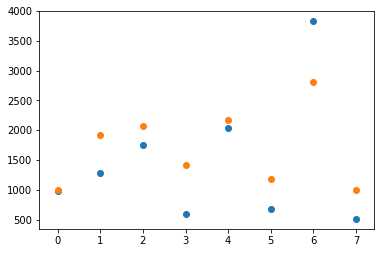

In [25]:
#preds =model.predict(xgboost.DMatrix(original_split['original_data_cluster0']))
plt.scatter(np.arange(len(original_split['original_test_label_cluster0'])),original_split['original_test_label_cluster0'])
plt.scatter(np.arange(len(original_split['original_test_label_cluster0'])),model_dict['model0'].predict(xgboost.DMatrix(original_split['original_test_cluster0'])))

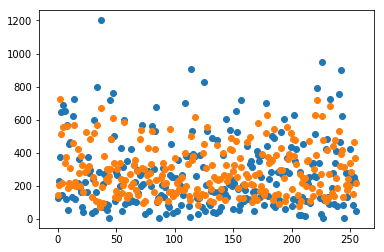

In [26]:
#preds =model.predict(xgboost.DMatrix(original_split['original_data_cluster0']))
plt.scatter(np.arange(len(original_split_shapley['original_test_label_cluster0'])),original_split_shapley['original_test_label_cluster0'])
plt.scatter(np.arange(len(original_split_shapley['original_test_label_cluster0'])),model_dict_shapley['model0'].predict(xgboost.DMatrix(original_split_shapley['original_test_cluster0'])))

In [27]:
#Train overall model
ev_result = {}
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse",
}
model = xgboost.train(params,xgboost.DMatrix(X_train, label=y_train),10000,evals = [(xgboost.DMatrix(X_train, label=y_train), "train"),(xgboost.DMatrix(X_test, label=y_test), "test")] ,verbose_eval = 1000,evals_result = ev_result,early_stopping_rounds = 200)
tot_result_big_model = min(ev_result['test']['rmse'])

[0]	train-rmse:592.015	test-rmse:649.553
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[339]	train-rmse:321.056	test-rmse:386.736



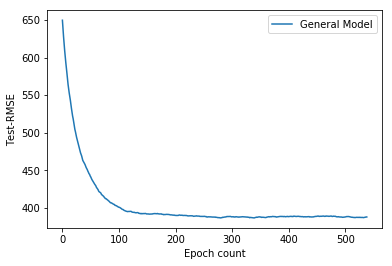

In [28]:
plt.plot(np.arange(len(ev_result['test']['rmse'])),ev_result['test']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Test-RMSE')
plt.legend(['General Model'])

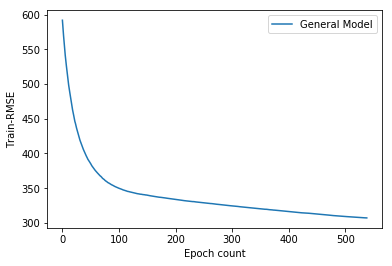

In [29]:
plt.plot(np.arange(len(ev_result['train']['rmse'])),ev_result['train']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Train-RMSE')
plt.legend(['General Model'])

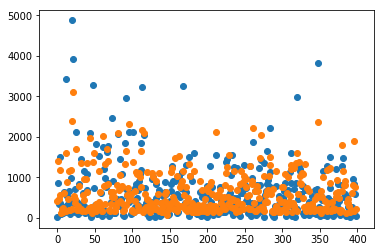

In [30]:
plt.scatter(np.arange(len(X_test)),y_test)
plt.scatter(np.arange(len(X_test)),model.predict(xgboost.DMatrix(X_test)))

In [31]:
#Evaluation of results
from Framework import metrics
sizes = []
rmse_array = []
for i in range(nClusters):
    sizes.append(len(original_split['original_test_label_cluster{0}'.format(i)]))
    rmse_array.append(min(eval_results['eval{0}'.format(i)]['test']['rmse']))
tot_rmse_org = metrics.ensembleRMSE(sizes,rmse_array)

sizes = []
rmse_array = []
for i in range(nClusters):
    sizes.append(len(original_split_shapley['original_test_label_cluster{0}'.format(i)]))
    rmse_array.append(min(eval_results_shapley['eval{0}'.format(i)]['test']['rmse']))
tot_rmse_shap = metrics.ensembleRMSE(sizes,rmse_array)

In [32]:
#Do PCA for dimensionality reduction
nPcaComponents = 2
pca = PCA(n_components=nPcaComponents)
shap_values_pca = pca.fit_transform(shap_values)
print(pca.explained_variance_ratio_.sum())

0.8510434


In [33]:
#Do PCA for dimensionality reduction
nPcaComponents = 2
pca_org = PCA(n_components=nPcaComponents)
org_values_pca = pca_org.fit_transform(X)
print(pca_org.explained_variance_ratio_.sum())

0.9840700295360734


Text(0, 0.5, 'Second principal component')

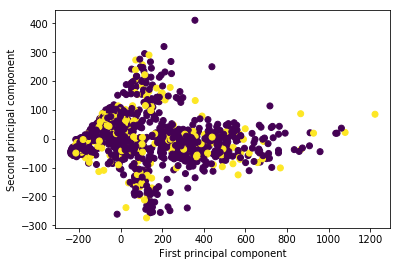

In [34]:
#PCA Clusters are quite seperate,could be used in clustering
label_colors = [ 0 if a == 'train' else 1 for a in X_instanced['instance']]
plt.scatter(shap_values_pca[:,0],shap_values_pca[:,1], c = label_colors)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
#Add to labels to the scatter plot (Colors)
#How do we interpret this ?

In [35]:
kmeans_pca = cluster.clusterData(KMeans(n_clusters=nPcaComponents, random_state=0).fit,shap_values_pca)
kmeans_org_pca = cluster.clusterData(KMeans(n_clusters=nPcaComponents, random_state=0).fit,org_values_pca)

Text(0, 0.5, 'Second principal component')

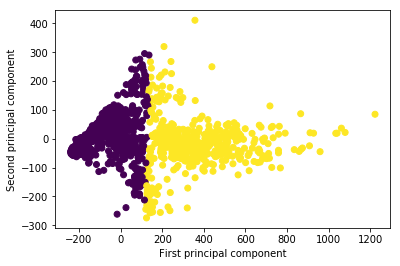

In [36]:
plt.scatter(shap_values_pca[:,0],shap_values_pca[:,1], c = kmeans_pca.labels_)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

In [37]:
data_dict_shap_pca = cluster.splitDataLabeled(2,shap_values_pca,kmeans_pca.labels_)
data_dict_org_pca = cluster.splitDataLabeled(2,org_values_pca,kmeans_org_pca.labels_)

In [38]:
pca_instanced = pd.concat((pd.DataFrame(org_values_pca),pd.DataFrame(columns = ['instance'])),axis = 1)
pca_instanced['instance'].loc[X_train.index] = 'train'
pca_instanced['instance'].loc[X_test.index] = 'test'
shap_pca_instanced = pd.concat((pd.DataFrame(shap_values_pca),pd.DataFrame(columns = ['instance'])),axis = 1)
shap_pca_instanced['instance'].loc[X_train.index] = 'train'
shap_pca_instanced['instance'].loc[X_test.index] = 'test'

C:\Users\koral\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [45]:
original_shap_pca = cluster.convertOriginalData(data_dict_shap_pca,shap_pca_instanced,y_instanced)
original_pca = cluster.convertOriginalData(data_dict_org_pca,pca_instanced,y_instanced)
original_shap_pca

{'original_data_cluster0':                0           1 instance
 0    -232.731964  -53.545792    train
 1    -212.515228  -27.503788     test
 2    -189.450638  -12.059858    train
 3      89.650101   99.828972    train
 4     -61.881725   80.513557    train
 5    -182.380112  -21.369204     test
 7    -194.627945  -22.061443    train
 9      23.446686  100.946922     test
 13   -184.461456  -24.400381    train
 14   -150.285736   16.776865     test
 15   -187.239090  -16.113445    train
 16   -128.387436    3.429642    train
 18   -133.295212   -9.851942     test
 19   -127.586281   30.863592     test
 20    -59.659462   26.638622    train
 21   -161.771545   13.407169    train
 22   -169.591888    0.289273    train
 23     27.285185   52.883480    train
 24    -53.007977   36.313606    train
 27    -18.831144   31.525965     test
 28     27.232780  152.982117    train
 29   -184.678558  -17.150267    train
 30   -165.133850   -5.347523     test
 31    -75.029152   70.402687    train

In [40]:
#Train split XGBoost models over original data
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse"
}
eval_results_org_pca = {}
kwargs = {
    'num_boost_round':10000,
    'verbose_eval': 1000,
    'evals_result' : {},
    'early_stopping_rounds' : 200
}
model_dict_org_pca,eval_results_org_pca = cluster.trainMultipleModels(xgboost.train,original_pca,'XGBoost',params,**kwargs)

[0]	train-rmse:597.92	test-rmse:652.623
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[568]	train-rmse:515.942	test-rmse:580.607

[0]	train-rmse:1825.69	test-rmse:1508.63
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[140]	train-rmse:318.233	test-rmse:1.1731



In [41]:
#Train split XGBoost models over original data
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse"
}
eval_results_shap_pca = {}
kwargs = {
    'num_boost_round':10000,
    'verbose_eval': 1000,
    'evals_result' : {},
    'early_stopping_rounds' : 200
}
model_dict_shap_pca,eval_results_shap_pca = cluster.trainMultipleModels(xgboost.train,original_shap_pca,'XGBoost',params,**kwargs)

[0]	train-rmse:377.048	test-rmse:366.565
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[264]	train-rmse:208.91	test-rmse:197.669

[0]	train-rmse:983.472	test-rmse:1202.84
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
[1000]	train-rmse:304.91	test-rmse:406.335
Stopping. Best iteration:
[831]	train-rmse:309.255	test-rmse:399.288



In [42]:
sizes = []
rmse_array = []
for i in range(2):
    sizes.append(len(original_shap_pca['original_test_label_cluster{0}'.format(i)]))
    rmse_array.append(min(eval_results_shap_pca['eval{0}'.format(i)]['test']['rmse']))
tot_rmse_shap_pca = metrics.ensembleRMSE(sizes,rmse_array)

sizes = []
rmse_array = []
for i in range(2):
    sizes.append(len(original_pca['original_test_label_cluster{0}'.format(i)]))
    rmse_array.append(min(eval_results_org_pca['eval{0}'.format(i)]['test']['rmse']))
tot_rmse_org_pca = metrics.ensembleRMSE(sizes,rmse_array)

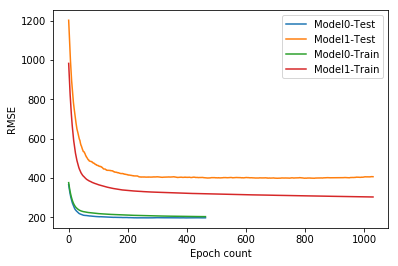

In [43]:
plt.plot(np.arange(len(eval_results_shap_pca['eval0']['test']['rmse'])),eval_results_shap_pca['eval0']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shap_pca['eval1']['test']['rmse'])),eval_results_shap_pca['eval1']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shap_pca['eval0']['train']['rmse'])),eval_results_shap_pca['eval0']['train']['rmse'])
plt.plot(np.arange(len(eval_results_shap_pca['eval1']['train']['rmse'])),eval_results_shap_pca['eval1']['train']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('RMSE')
plt.legend(['Model0-Test','Model1-Test','Model0-Train','Model1-Train'])

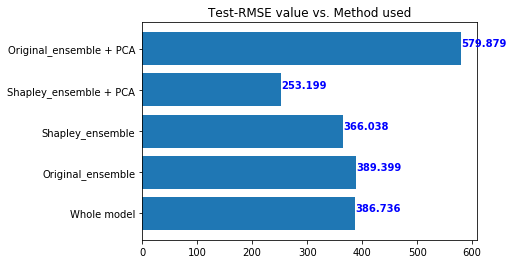

In [44]:
ax = plt.figure()
plt.barh(['Whole model','Original_ensemble','Shapley_ensemble','Shapley_ensemble + PCA','Original_ensemble + PCA'],[tot_result_big_model,tot_rmse_org,tot_rmse_shap,tot_rmse_shap_pca,tot_rmse_org_pca])
plt.title('Test-RMSE value vs. Method used')
for i,v in enumerate([tot_result_big_model,tot_rmse_org,tot_rmse_shap,tot_rmse_shap_pca,tot_rmse_org_pca]):
    plt.text(v , i + .05, '{0:.3f}'.format(v), color='blue', fontweight='bold')